<a href="https://colab.research.google.com/github/thanawat150/GeoAI/blob/main/Material/Day%203/Excercise/BuildingSegmentation01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://zenodo.org/records/16948350/files/WHU_buildings.zip?download=1 -O WHU_buildings.zip
# Unzip
!unzip -q WHU_buildings.zip -d ./WHU_buildings

--2025-08-27 07:59:24--  https://zenodo.org/records/16948350/files/WHU_buildings.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116403828 (111M) [application/octet-stream]
Saving to: ‘WHU_buildings.zip’

WHU_buildings.zip   100%[===================>] 111.01M  3.14MB/s    in 63s     

2025-08-27 08:00:27 (1.76 MB/s) - ‘WHU_buildings.zip’ saved [116403828/116403828]



In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

# --- 1. Set paths (adjust to your download) ---
img_dir = "/content/WHU_buildings/Satellite dataset вё (global cities)/image"   # raw aerial images
mask_dir = "/content/WHU_buildings/Satellite dataset вё (global cities)/label"   # corresponding building masks

In [3]:

# --- 2. Load data ---
X, Y = [], []
files = sorted(os.listdir(img_dir))

for f in files:
    img = imread(os.path.join(img_dir, f))
    mask = imread(os.path.join(mask_dir, f.replace(".jpg", ".png"))).max(axis=-1)  # adjust ext

    # ensure mask is binary (0=background, 1=building)
    mask = (mask > 127).astype(np.uint8)

    X.append(img)
    Y.append(mask[..., np.newaxis])  # keep channel dimension

X = np.array(X, dtype=np.float32) / 255.0
Y = np.array(Y, dtype=np.float32)

print("Images:", X.shape, "Masks:", Y.shape)

# --- 3. Train/test split ---
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)


Images: (204, 512, 512, 3) Masks: (204, 512, 512, 1)


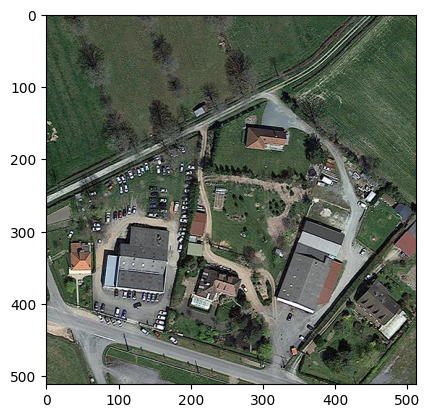

In [10]:
import matplotlib.pyplot as plt
plt.imshow(X_train[25])
# CNN modal

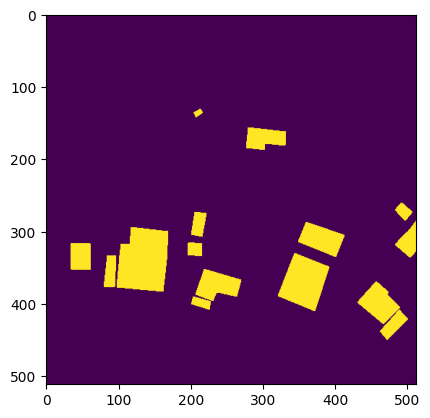

In [11]:
plt.imshow(Y_train[25])

In [12]:

# --- 4. Define U-Net model ---
def unet(input_size=(512,512,3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(64, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(64, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(128, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(128, 3, activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(256, 3, activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(256, 3, activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(512, 3, activation="relu", padding="same")(p4)
    c5 = layers.Conv2D(512, 3, activation="relu", padding="same")(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(256, 2, strides=(2,2), padding="same")(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, 3, activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(256, 3, activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(128, 2, strides=(2,2), padding="same")(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, 3, activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(128, 3, activation="relu", padding="same")(c7)

    u8 = layers.Conv2DTranspose(64, 2, strides=(2,2), padding="same")(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, 3, activation="relu", padding="same")(u8)
    c8 = layers.Conv2D(64, 3, activation="relu", padding="same")(c8)

    u9 = layers.Conv2DTranspose(32, 2, strides=(2,2), padding="same")(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, 3, activation="relu", padding="same")(u9)
    c9 = layers.Conv2D(32, 3, activation="relu", padding="same")(c9)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c9)

    return models.Model(inputs, outputs)

model = unet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 512, 512,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 512, 512,  │      9,248 │ conv2d_19[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 256, 256,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 256, 256,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_21[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 128, 128,  │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_23[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_25[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_7[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_27[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 64, 64,    │    524,544 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 7,760,097 (29.60 MB)

 Trainable params: 7,760,097 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- 5. Train ---
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=8, epochs=20
)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1469s 70s/step - accuracy: 0.7276 - loss: 0.6441 - val_accuracy: 0.7201 - val_loss: 0.6232
Epoch 2/20
14/21 ━━━━━━━━━━━━━━━━━━━━ 7:47 67s/step - accuracy: 0.7479 - loss: 0.5847

ดูการทำงาน https://netron.app/

คอนแทน จารย์ https://people.utwente.nl/a.dahal

In [ ]:
model.save('seg_model.keras')

In [ ]:
model.load_weights('seg_model.keras')

In [ ]:
tf.keras.models.save_model('seg_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


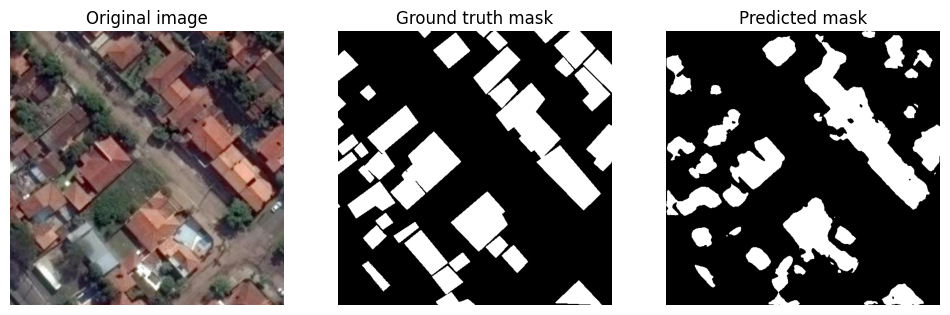

In [ ]:

# --- 6. Inference ---
idx = np.random.randint(0, len(X_test))
test_img = X_test[idx]
true_mask = Y_test[idx].squeeze()
pred_mask = (model.predict(test_img[np.newaxis,...])[0,...,0] > 0.5).astype(np.uint8)

# --- 7. Plot results ---
fig, axs = plt.subplots(1, 3, figsize=(12,5))
axs[0].imshow(test_img)
axs[0].set_title("Original image")
axs[0].axis("off")

axs[1].imshow(true_mask, cmap="gray")
axs[1].set_title("Ground truth mask")
axs[1].axis("off")

axs[2].imshow(pred_mask, cmap="gray")
axs[2].set_title("Predicted mask")
axs[2].axis("off")

plt.show()